# Code-graded eval: classification task

In this lesson, we'll implement a slightly more complex code-graded evaluation from scratch to test a customer complaint classification prompt.  Our goal is to write a prompt that can reliably classify customer complaints into the following categories: 

* Software Bug
* Hardware Malfunction
* User Error
* Feature Request
* Service Outage

For example, the following complaint text: 

> The website is completely down, I can't access any pages

Should be classified as `Service Outage`

In some cases, we may want allow up to two applicable classification categories, as in this example: 

> I think I installed something incorrectly, and now my computer won't start at all

which should be classified as both `User Error` and `Hardware Malfunction`

---


## The Evaluation data set

We'll start by defining our evaluation data set of inputs and golden answers.  Remember that generally we want an evaluation data set of around 100 inputs, but to keep these lessons simple (and quick and affordable to run), we're using a slimmed down set.

This test set consists of a list of dictionaries where each dictionary contains a `complaint` and `golden_answer` key:

In [2]:
eval_data = [
    {
        "complaint": "The app crashes every time I try to upload a photo",
        "golden_answer": ["Software Bug"]
    },
    {
        "complaint": "My printer isn't recognized by my computer",
        "golden_answer": ["Hardware Malfunction"]
    },
    {
        "complaint": "I can't figure out how to change my password",
        "golden_answer": ["User Error"]
    },
    {
        "complaint": "The website is completely down, I can't access any pages",
        "golden_answer": ["Service Outage"]
    },
    {
        "complaint": "It would be great if the app had a dark mode option",
        "golden_answer": ["Feature Request"]
    },
    {
        "complaint": "The software keeps freezing when I try to save large files",
        "golden_answer": ["Software Bug"]
    },
    {
        "complaint": "My wireless mouse isn't working, even with new batteries",
        "golden_answer": ["Hardware Malfunction"]
    },
    {
        "complaint": "I accidentally deleted some important files, can you help me recover them?",
        "golden_answer": ["User Error"]
    },
    {
        "complaint": "None of your servers are responding, is there an outage?",
        "golden_answer": ["Service Outage"]
    },
    {
        "complaint": "Could you add a feature to export data in CSV format?",
        "golden_answer": ["Feature Request"]
    },
    {
        "complaint": "The app is crashing and my phone is overheating",
        "golden_answer": ["Software Bug", "Hardware Malfunction"]
    },
    {
        "complaint": "I can't remember my password!",
        "golden_answer": ["User Error"]
    },
    {
        "complaint": "The new update broke something and the app no longer works for me",
        "golden_answer": ["Software Bug"]
    },
    {
        "complaint": "I think I installed something incorrectly, now my computer won't start at all",
        "golden_answer": ["User Error", "Hardware Malfunction"]
    },
    {
        "complaint": "Your service is down, and I urgently need a feature to batch process files",
        "golden_answer": ["Service Outage", "Feature Request"]
    },
    {
        "complaint": "The graphics card is making weird noises",
        "golden_answer": ["Hardware Malfunction"]
    },
    {
        "complaint": "My keyboard just totally stopped working out of nowhere",
        "golden_answer": ["Hardware Malfunction"]
    },
    {
        "complaint": "Whenever I open your app, my phone gets really slow",
        "golden_answer": ["Software Bug"]
    },
    {
        "complaint": "Can you make the interface more user-friendly? I always get lost in the menus",
        "golden_answer": ["Feature Request", "User Error"]
    },
    {
        "complaint": "The cloud storage isn't syncing and I can't access my files from other devices",
        "golden_answer": ["Software Bug", "Service Outage"]
    }
]

--- 

## An initial prompt

We'll start with a basic prompt and measure how it performs.  The prompt-generating function below takes a `complaint` as an argument and returns a prompt string:

In [3]:
def basic_prompt(complaint):
    return f"""
    Classify the following customer complaint into one or more of these categories: 
    Software Bug, Hardware Malfunction, User Error, Feature Request, or Service Outage.
    Only respond with the matching category or categories and nothing else.

    Complaint: {complaint}

    Classification:
    """

---

## Collecting outputs

Next, we'll write the logic to evaluate the prompt.  This logic is a bit more complex than our "leg-counting" example from the previous lesson:

In [4]:
from anthropic import Anthropic
from dotenv import load_dotenv

load_dotenv()
client = Anthropic()

def get_model_response(prompt, model_name):
    response = client.messages.create(
        model=model_name,
        max_tokens=200,
        messages=[{'role': 'user', 'content': prompt}]
    )
    return response.content[0].text

def calculate_accuracy(eval_data, model_responses):
    correct_predictions = 0
    total_predictions = len(eval_data)
    
    for item, response in zip(eval_data, model_responses):
        golden_set = set(category.lower() for category in item["golden_answer"])
        prediction_set = set(category.strip().lower() for category in response.split(','))
        
        if golden_set == prediction_set:
            correct_predictions += 1
    
    return correct_predictions / total_predictions

def evaluate_prompt(prompt_func, eval_data, model_name):
    print(f"Evaluating with model: {model_name}")
    model_responses = [get_model_response(prompt_func(item['complaint']), model_name) for item in eval_data]
    accuracy = calculate_accuracy(eval_data, model_responses)
    
    print(f"Accuracy: {accuracy:.2%}")
    
    for item, response in zip(eval_data, model_responses):
        print(f"\nComplaint: {item['complaint']}")
        print(f"Golden Answer: {item['golden_answer']}")
        print(f"Model Response: {response}")
    return accuracy

The `evaluate_prompt` function does the following:

1. It passes each input into our prompt-generating function and runs the resulting prompt through the model using the `get_model_response` function, collecting the responses as they're generated.
2. It calculates the accuracy by comparing the model output answers to the golden answers in our data set. To do this it calls the `calculate_accuracy` function.
3. The `calculate_accuracy` function checks to see if the appropriate classification categories are present in each of the model's outputs, using a `set`.  Remember, this is not an exact-match eval like our previous "leg-counting" eval.
4. `calculate_accuracy` returns an accuracy score
5. `evaluate_prompt` prints the final results

**Note that instead of grading via exact string match, as we did in the previous lesson, our grading logic uses a `set` to check for the presence of values in the model output.**

Let's test it out with our initial `basic_prompt`

In [5]:
evaluate_prompt(basic_prompt, eval_data, model_name="claude-3-haiku-20240307")

Evaluating with model: claude-3-haiku-20240307
Accuracy: 85.00%

Complaint: The app crashes every time I try to upload a photo
Golden Answer: ['Software Bug']
Model Response: Software Bug

Complaint: My printer isn't recognized by my computer
Golden Answer: ['Hardware Malfunction']
Model Response: Hardware Malfunction

Complaint: I can't figure out how to change my password
Golden Answer: ['User Error']
Model Response: User Error

Complaint: The website is completely down, I can't access any pages
Golden Answer: ['Service Outage']
Model Response: Service Outage

Complaint: It would be great if the app had a dark mode option
Golden Answer: ['Feature Request']
Model Response: Feature Request

Complaint: The software keeps freezing when I try to save large files
Golden Answer: ['Software Bug']
Model Response: Software Bug

Complaint: My wireless mouse isn't working, even with new batteries
Golden Answer: ['Hardware Malfunction']
Model Response: Hardware Malfunction

Complaint: I accidenta

0.85

---

## An improved prompt
Our initial prompt resulted in an 85% accuracy score.  Let's make some changes to the prompt and rerun the evaluation, hopefully resulting in a better score.

The following prompt incorporates an expanded explanation of the categories, as well as 9 example input/output pairs:

In [6]:
def improved_prompt(complaint):
    return f"""
    You are an AI assistant specializing in customer support issue classification. Your task is to analyze customer complaints and categorize them into one or more of the following categories:

    1. Software Bug: Issues related to software not functioning as intended.
    2. Hardware Malfunction: Problems with physical devices or components.
    3. User Error: Difficulties arising from user misunderstanding or misuse.
    4. Feature Request: Suggestions for new functionalities or improvements.
    5. Service Outage: System-wide issues affecting service availability.

    Important Guidelines:
    - A complaint may fall into multiple categories. If so, list all that apply but try to prioritize picking a single category when possible.

    Examples:
    1. Complaint: "The app crashes when I try to save my progress."
    Classification: Software Bug

    2. Complaint: "My keyboard isn't working after I spilled coffee on it."
    Classification: Hardware Malfunction

    3. Complaint: "I can't find the login button on your website."
    Classification: User Error

    4. Complaint: "It would be great if your app had a dark mode."
    Classification: Feature Request

    5. Complaint: "None of your services are loading for me or my colleagues."
    Classification: Service Outage

    6. Complaint "Complaint: The app breaks every time I try to change my profile picture"
    Classification: Software Bug

    7. Complaint "The app is acting buggy on my phone and it seems like your website is down, so I'm completely stuck!"
    Classification: Software Bug, Service Outage

    8. Complaint: "Your software makes my computer super laggy and awful, I hate it!"
    Classification: Software Bug

    9. Complaint: "Your dumb app always breaks when I try to do anything with images."
    Classification: 'Software Bug'

    Now, please classify the following customer complaint:

    <complaint>{complaint}</complaint>

    Only respond with the appropriate categories and nothing else.
    Classification:
    """

Let's run the evaluation with our improved prompt:

In [80]:
evaluate_prompt(improved_prompt, eval_data, model_name="claude-3-haiku-20240307")

Evaluating with model: claude-3-haiku-20240307
Accuracy: 100.00%

Complaint: The app crashes every time I try to upload a photo
Golden Answer: ['Software Bug']
Model Response: Software Bug

Complaint: My printer isn't recognized by my computer
Golden Answer: ['Hardware Malfunction']
Model Response: Hardware Malfunction

Complaint: I can't figure out how to change my password
Golden Answer: ['User Error']
Model Response: User Error

Complaint: The website is completely down, I can't access any pages
Golden Answer: ['Service Outage']
Model Response: Service Outage

Complaint: It would be great if the app had a dark mode option
Golden Answer: ['Feature Request']
Model Response: Feature Request

Complaint: The software keeps freezing when I try to save large files
Golden Answer: ['Software Bug']
Model Response: Software Bug

Complaint: My wireless mouse isn't working, even with new batteries
Golden Answer: ['Hardware Malfunction']
Model Response: Hardware Malfunction

Complaint: I accident

1.0

We got 100% accuracy with the newer, improved prompt! 

Again, we're following the standard prompt + eval loop outlined in this diagram:

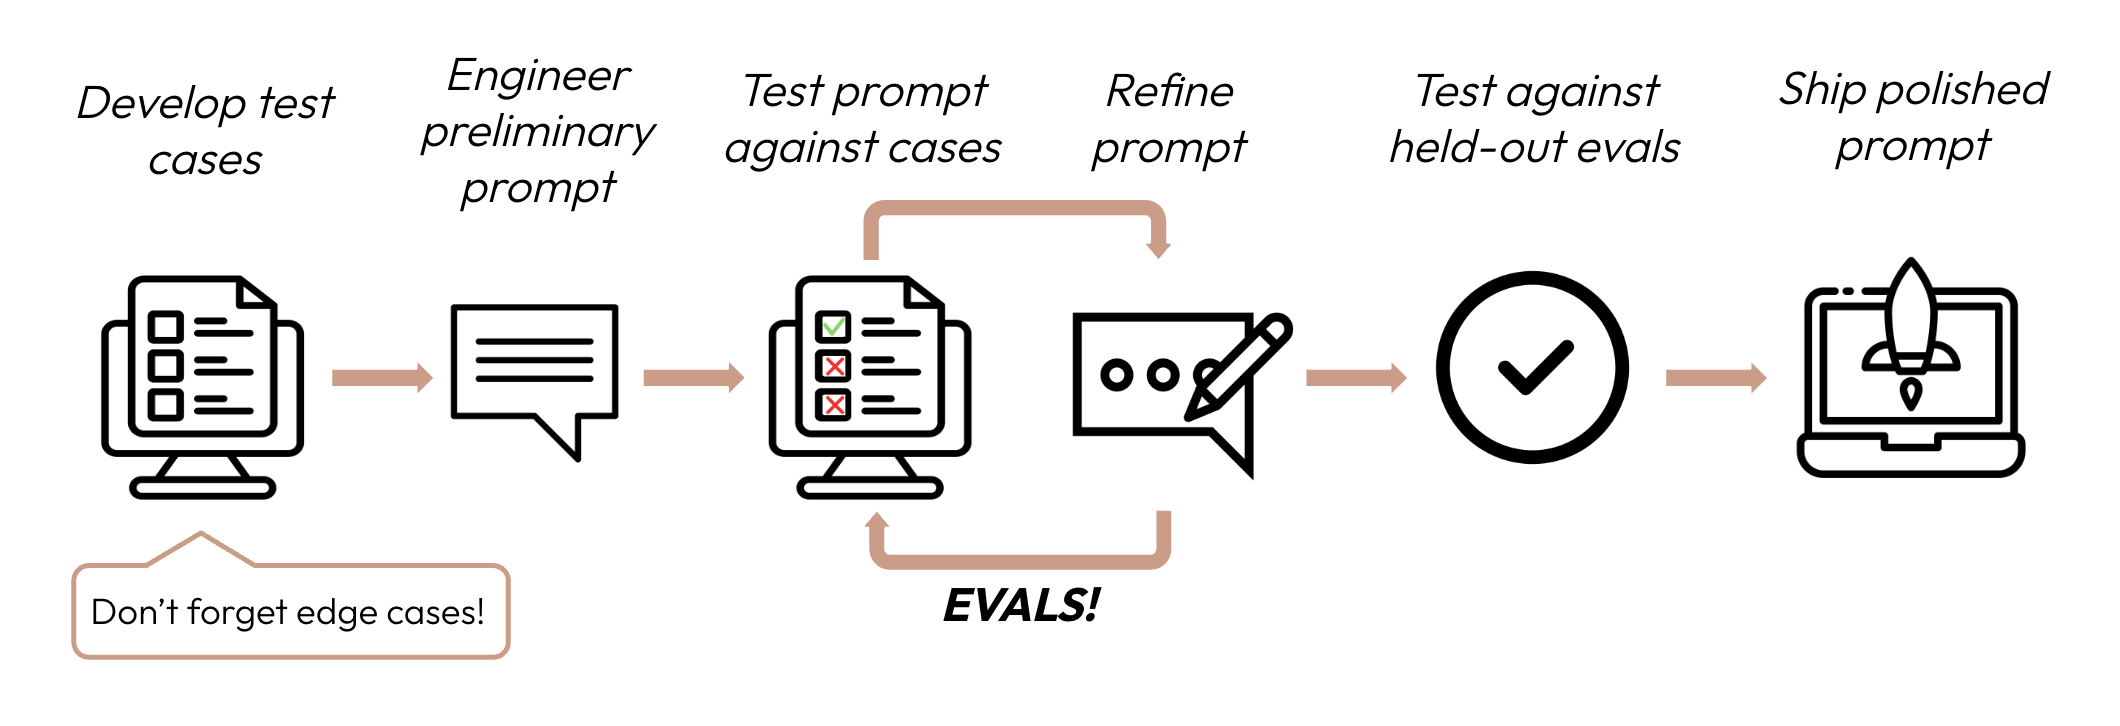

**Please keep in mind that this is a very simple evaluation, using a very small dataset.  This lesson aims to illustrate the general process of code-graded evaluations, but it is not meant as a canonical example of a production-scale evaluation!**

This approach works, but it's a bit laborious to write all the evaluation logic from scratch, and it's difficult to compare results side-by-side.  What if we used a tool that generated nicely-formatted results with charts and graphs and made it easy to run an evaluation across multiple models?  In the next lesson, we'll see just that! Next up, we'll take a look at an evaluation framework that makes it easy to write repeatable, scalable evaluations for production use-cases.